# Implémentation de l'architecture des réseaux de neurones

*http://exo7.emath.fr/cours/livre-deepmath.pdf* 

## Chargement des modules et données

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow import keras

from sklearn import preprocessing, model_selection

In [4]:
df = pd.read_csv('market_data_pd.csv',sep=',')

In [6]:
df.head()

df = df[df.PD_1y>0.0]
df = df[df.PD_1y!=1.0]
#df = df[df['Common Eqty / Tot Assets']<.4]

In [4]:
#df.dtypes

In [8]:
#mettre les ratios financiers
df1 = df[["Common Eqty / Tot Assets",'Debt / Common Equity','BCLASS Level 3',"TCE Ratio","PD_1y"]]

#df1 = df.drop(columns=['Unnamed: 0','Reference Security', 'Ticker_y','Ticker_x', 'Issuer Name','Maturity','Cpn', 'Bid Price', 'Ask Price'])

#df2 = pd.read_csv('PD_1y.csv')

df1['PD_1y'] = pd.read_csv('PD_1y.csv')['PD_1y']
df1.replace(np.nan, 0.0,inplace=True)


<ipython-input-8-a7e076bb519c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['PD_1y'] = pd.read_csv('PD_1y.csv')['PD_1y']
C:\Users\mathilde.binet\Anaconda3\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [9]:
#df1 = df1.dropna(how = 'any') 
df1.head()
#on peut pas faire tourner l'algo avec des valeurs manquantes. Voir techniques pour les remplacer.

,Common Eqty / Tot Assets,Debt / Common Equity,BCLASS Level 3,TCE Ratio,PD_1y
0,4.84431,684.499,Banking,4.45822,0.006788
1,17.15800,351.535,Consumer Cyclical,-171.02700,0.065377
2,17.15800,351.535,Consumer Cyclical,-171.02700,0.116526
3,19.24570,410.513,Basic Industry,0.00000,0.014829
4,19.24570,410.513,Basic Industry,0.00000,0.009303


In [10]:
df1.shape

(549, 5)

# Traitement des données

Nous commencerons par séparer les données non étiquietées des étiquettes, les étiquettes se trouvent dans l'array `y_full` et le reste des données dans `X_full`

In [11]:
X_full = np.array(df1.drop(columns=['PD_1y']))
y_full = np.array(df1['PD_1y'])

La prochaine étape consiste à séparer les features continues des features discrètes, cela sera utile car leurs traitements seront différent

In [12]:
features = list(df1.drop(columns=['PD_1y']).columns)

discrete_features = ['BCLASS Level {}'.format(i) for i in range(3,4)]
continuous_features = [s for s in features if not s in discrete_features]


continuous_features_idx = [features.index(feat_name) for feat_name in continuous_features]
discrete_features_idx = [features.index(feat_name) for feat_name in discrete_features]

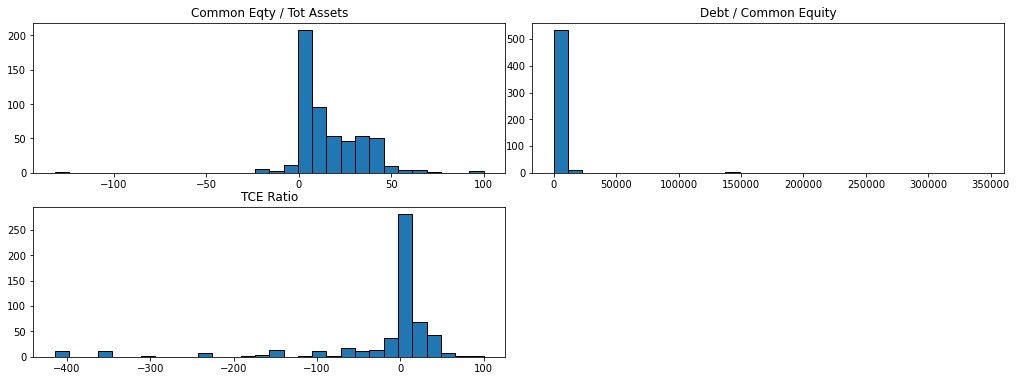

In [13]:
fig = plt.figure(figsize=(14,10))

# Histograms for continuous features
for (plot_idx, feat_idx) in enumerate(continuous_features_idx):
    # create a subplot in the (plot_idx+1) position of a 2x2 grid
    ax = fig.add_subplot(4, 2, (plot_idx+1))
    # plot the histogram of feat_idx
    h = ax.hist(X_full[:, feat_idx], bins=30, edgecolor='black')
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
# espacement entre les subplots
fig.tight_layout(pad=0.1)

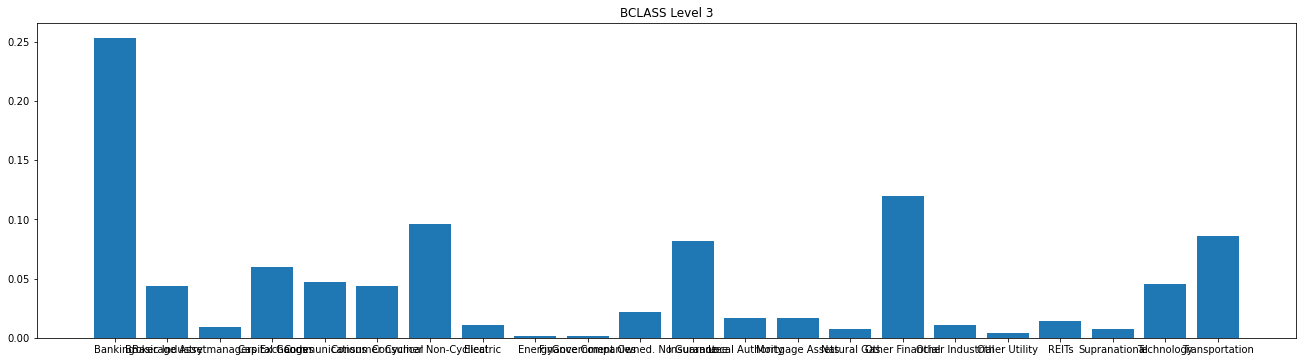

In [14]:
# Bar plots for discrete features
fig = plt.figure(figsize=(18, 14))

for (plot_idx, feat_idx) in enumerate(discrete_features_idx):
    # create a subplot in the (plot_idx+1) position of a 1x3 grid
    ax = fig.add_subplot(3, 1, (plot_idx+1))

    feature_values = np.unique(X_full[:, feat_idx])
    frequencies = [(float(len(np.where(X_full[:, feat_idx]==value)[0]))/X_full.shape[0]) \
                   for value in feature_values]
    
    b = ax.bar(range(len(feature_values)), frequencies, width=0.8, 
               tick_label=list([n for n in feature_values]))
    
    
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
fig.tight_layout(pad=0.35)

In [15]:
def traitement(X):
    
    ohe = preprocessing.OneHotEncoder(categories='auto',sparse=False)
    
    std_scaler = preprocessing.StandardScaler().fit(X[:,continuous_features_idx])
    X_continuous_scaled = std_scaler.transform(X[:,continuous_features_idx])
    
    X_processed = np.hstack((ohe.fit_transform(X[:,discrete_features_idx]), X_continuous_scaled))
    
    return X_processed



In [16]:
X_processed = traitement(X_full)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_processed, y_full, test_size=0.10,
                                                                    #stratify=y_full, # stratification
                                                                    random_state=92)

In [17]:
X_train.shape

(494, 25)

## Réseaux de neurones 

In [16]:
#RESEAUX DE NEURONES 
#http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Packages_Python_for_Deep_Learning.pdf

#Explications très bien dans ce document : 

#http://exo7.emath.fr/cours/livre-deepmath.pdf 

#très bon document (parties Python, keras avec les codes et explications)

In [19]:
model = Sequential()
model.add(Dense(units=6,input_dim=25,activation="sigmoid")) #6 is good
model.add(Dense(units=2))
model.add(Dense(units=1,activation="sigmoid"))
#modele.add(Dropout(0.3))
learning_rate = 0.10

sgd = SGD(learning_rate)

#dim première couche = nombre de variables du df 

J'ai pris la fonction sigmoïde car elle est continue et à valeurs dans [0,1] (comme les probabilités de défaut). Régression logit. 

In [20]:
#modele.compile(loss='mean_squared_error',optimizer=sgd,metrics=[tf.keras.metrics.MeanSquaredError()])
#optimizer = sgd
model.compile(loss='mean_squared_error',optimizer='adam',metrics=[tf.keras.metrics.MeanSquaredError()])

In [21]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6)                 156       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 14        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
40/40 [==============================] - 1s 8ms/step - loss: 0.2168 - mean_squared_error: 0.2168 - val_loss: 0.1727 - val_mean_squared_error: 0.1727
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 0.1345 - mean_squared_error: 0.1345 - val_loss: 0.1075 - val_mean_squared_error: 0.1075
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 0.0803 - mean_squared_error: 0.0803 - val_loss: 0.0695 - val_mean_squared_error: 0.0695
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 0.0510 - mean_squared_error: 0.0510 - val_loss: 0.0475 - val_mean_squared_error: 0.0475
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0268 - val_mean_squared_error: 0.0268
Epoch 7/50
40/40 [======================

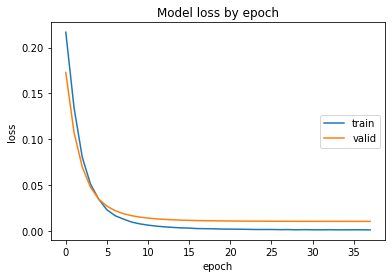

In [22]:
history = model.fit(X_train, y_train,         # Train the model using the training set...
          batch_size=10, epochs=50,
          verbose=1, validation_split=0.4,steps_per_epoch=40)           # ...holding out 40% of the data for validation

# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

    
import matplotlib.pyplot as plt

# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

In [23]:
#Résultats 

resultat = model.evaluate(X_test, y_test, verbose=1)
print("Valeur de l'erreur sur les données de test (loss):", resultat[0])
print('Précision sur les données de test (MSE):', resultat[1])

2/2 [==============================] - 0s 4ms/step - loss: 5.9562e-04 - mean_squared_error: 5.9562e-04
Valeur de l'erreur sur les données de test (loss): 0.000595622870605439
Précision sur les données de test (MSE): 0.000595622870605439


## Observation des résultats 

In [24]:
def ecart_relatif(row) : 
    théo = row['Théorique']
    préd = row['Prédiction']
    return abs(théo - préd) / théo

In [25]:
prediction = pd.DataFrame(data= model.predict(X_test) ,columns=['Prédiction'])
théorique = pd.DataFrame(data= y_test ,columns=['Théorique'])
prediction, théorique = prediction.reset_index() , théorique.reset_index()

results = pd.merge(théorique, prediction, on = 'index').drop(columns=['index'])
results["Ecart_relatif"] = results.apply(ecart_relatif,axis=1)

<ipython-input-24-4a18010dd972>:4: RuntimeWarning: divide by zero encountered in double_scalars
  return abs(théo - préd) / théo


In [26]:
results.replace(np.inf, 0.0,inplace=True)

In [27]:
results["Ecart_relatif"].mean()

4.498777487054001

In [28]:
print("L'écart relatif moyen est de " + str(results["Ecart_relatif"].mean() * 100) + "%")

L'écart relatif moyen est de 449.8777487054001%


In [29]:
results.sort_values('Ecart_relatif',inplace=True)

In [31]:
#results

(-0.01, 0.1)

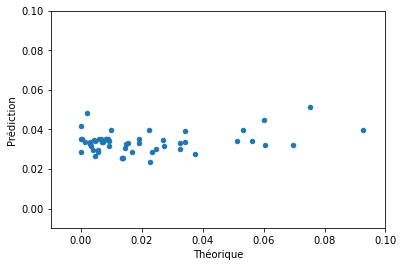

In [30]:
results.plot.scatter("Théorique","Prédiction")
plt.xlim(-.01,.1)
plt.ylim(-.01,.1)

---------------

# Test classification multi-classe

In [36]:
df = pd.read_csv('market_data_pd.csv',sep=',')
df = df[["Common Eqty / Tot Assets",'Debt / Common Equity','BCLASS Level 3',"PD_1y","TCE Ratio"]]
df = df[df.PD_1y>0.0]
df = df[df.PD_1y!=1.0]
df = df[df.PD_1y<0.05]

df['PD_1y'] = pd.read_csv('PD_1y.csv')['PD_1y']
df.replace(np.nan, 0.0,inplace=True)

In [ ]:
#ATTENTION : CHANGEMENT A FAIRE 
#il faut paramétrer les algorithmes de classification seulement en utilisant la base de train. 
#et ensuite seulement, appliquer la classification sur la base de test 

#sinon, tu utilises une base normalement inconnue (la base de test) pour paramétrer ton algo. 
#(même si le changement est pas ouf, il faut inverser l'ordre dans lequel on fait ça)

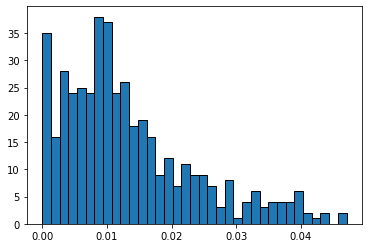

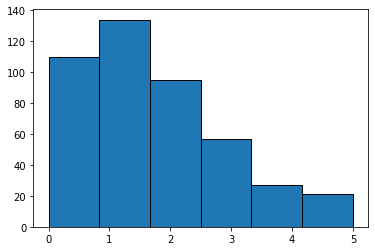

In [37]:
from numpy.random import randn
from sklearn.preprocessing import KBinsDiscretizer

data = np.array(df['PD_1y'])
# histogram of the raw data
plt.hist(data, bins=35,edgecolor='black')
plt.show()
# reshape data to have rows and columns
data = data.reshape((len(data),1))
# discretization transform the raw data
kbins = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='kmeans')
data_trans = kbins.fit_transform(data)

# summarize first few rows
#print(data_trans[:10, :])
# histogram of the transformed data
plt.hist(data_trans, bins=6,edgecolor='black' )
plt.show()

In [38]:
df['PD_1y'] = data_trans

In [39]:
X_full = np.array(df.drop(columns=['PD_1y']))
y_full = np.array(df['PD_1y'])

features = list(df.drop(columns=['PD_1y']).columns)

discrete_features = ['BCLASS Level {}'.format(i) for i in range(3,4)]
continuous_features = [s for s in features if not s in discrete_features]


continuous_features_idx = [features.index(feat_name) for feat_name in continuous_features]
discrete_features_idx = [features.index(feat_name) for feat_name in discrete_features]


X_processed = traitement(X_full)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_processed, y_full, test_size=0.30,
                                                                    stratify=y_full, # stratification
                                                                    random_state=92)

In [43]:
model = Sequential()
model.add(Dense(units=6,input_dim=25)) #6 is good
#model.add(Dense(units=2))
model.add(Dense(units=6,activation="sigmoid")) #output


In [44]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [629]:
#model.fit(X_train,y_train,validation_split=0.4, epochs=40)

In [45]:
history = model.fit(X_train, y_train,         # Train the model using the training set...
          batch_size=10, epochs=20,
          verbose=1, validation_split=0.4,steps_per_epoch=20)  

Epoch 1/20
20/20 [==============================] - 1s 12ms/step - loss: 1.8217 - sparse_categorical_accuracy: 0.1939 - val_loss: 1.8811 - val_sparse_categorical_accuracy: 0.1371
Epoch 2/20
20/20 [==============================] - 0s 4ms/step - loss: 1.8066 - sparse_categorical_accuracy: 0.1990 - val_loss: 1.8612 - val_sparse_categorical_accuracy: 0.1371
Epoch 3/20
20/20 [==============================] - 0s 4ms/step - loss: 1.7666 - sparse_categorical_accuracy: 0.2041 - val_loss: 1.8438 - val_sparse_categorical_accuracy: 0.1371
Epoch 4/20
20/20 [==============================] - 0s 4ms/step - loss: 1.7743 - sparse_categorical_accuracy: 0.1888 - val_loss: 1.8284 - val_sparse_categorical_accuracy: 0.1774
Epoch 5/20
20/20 [==============================] - 0s 4ms/step - loss: 1.7109 - sparse_categorical_accuracy: 0.2500 - val_loss: 1.8163 - val_sparse_categorical_accuracy: 0.1935
Epoch 6/20
20/20 [==============================] - 0s 4ms/step - loss: 1.7198 - sparse_categorical_accuracy:

5/5 [==============================] - 0s 2ms/step - loss: 1.6579 - sparse_categorical_accuracy: 0.2761
The final loss on the TEST set is: 1.66.
The final sparse_categorical_accuracy on the TEST set is: 0.28.


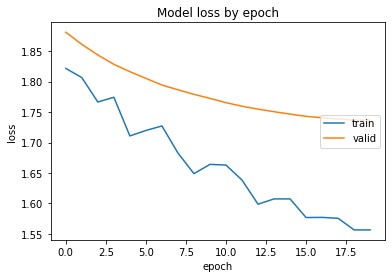

In [46]:
# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

In [47]:

y=model.predict(X_test)


In [48]:
y_predicted = [np.argmax(pred) for pred in y]

In [49]:
for i in range(len(y_predicted)):
    print("predicted: ", y_predicted[i], "| Actual Label: ",y_test[i], " True" if (y_predicted[i]==y_test[i]) else " False")
print("\n")
print(np.sum(y_predicted==y_test),'/',len(y_predicted))

predicted:  2 | Actual Label:  0.0  False
predicted:  1 | Actual Label:  3.0  False
predicted:  2 | Actual Label:  1.0  False
predicted:  2 | Actual Label:  2.0  True
predicted:  2 | Actual Label:  2.0  True
predicted:  1 | Actual Label:  5.0  False
predicted:  2 | Actual Label:  2.0  True
predicted:  2 | Actual Label:  1.0  False
predicted:  2 | Actual Label:  5.0  False
predicted:  2 | Actual Label:  3.0  False
predicted:  0 | Actual Label:  0.0  True
predicted:  2 | Actual Label:  0.0  False
predicted:  1 | Actual Label:  1.0  True
predicted:  2 | Actual Label:  2.0  True
predicted:  2 | Actual Label:  0.0  False
predicted:  2 | Actual Label:  0.0  False
predicted:  1 | Actual Label:  0.0  False
predicted:  1 | Actual Label:  1.0  True
predicted:  1 | Actual Label:  4.0  False
predicted:  2 | Actual Label:  2.0  True
predicted:  1 | Actual Label:  1.0  True
predicted:  2 | Actual Label:  3.0  False
predicted:  2 | Actual Label:  4.0  False
predicted:  2 | Actual Label:  2.0  True
pr

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [51]:
CM = confusion_matrix(y_test, y_predicted)

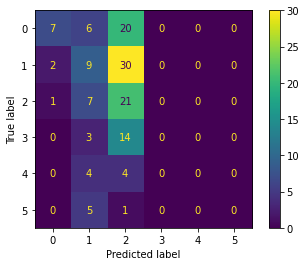

In [52]:
ConfusionMatrixDisplay(CM).plot()